In [14]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
url = 'E:\App Exes\VS Code\Proyecto Final Data\healthcare-dataset-stroke-data.csv'

In [15]:
df = pd.read_csv(url, sep = ',')
df = pd.get_dummies(df, columns=['work_type'], prefix='work_type')
df = pd.get_dummies(df, columns=['smoking_status'], prefix='smoking_status')
#Reemplaza valores nulos de BMI promediando por rango edades cercanas
promedio_bmi_edades = df.groupby('age')['bmi'].mean()
df['bmi'] = df.apply(lambda row: promedio_bmi_edades[row['age']] if pd.isnull(row['bmi']) else row['bmi'], axis=1)

#Reemplazo valores strings por valores numericos
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0, 'Other': 2})
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1})

df_stroke = df.loc[df['stroke'] == 1]
df_nostroke = df.loc[df['stroke'] == 0]

#Muestro el dataframe completo
df

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,1,228.69,36.600000,1,False,False,True,False,False,False,True,False,False
1,51676,0,61.0,0,0,1,0,202.21,30.190000,1,False,False,False,True,False,False,False,True,False
2,31112,1,80.0,0,1,1,0,105.92,32.500000,1,False,False,True,False,False,False,False,True,False
3,60182,0,49.0,0,0,1,1,171.23,34.400000,1,False,False,True,False,False,False,False,False,True
4,1665,0,79.0,1,0,1,0,174.12,24.000000,1,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,1,83.75,28.783582,0,False,False,True,False,False,False,False,True,False
5106,44873,0,81.0,0,0,1,1,125.20,40.000000,0,False,False,False,True,False,False,False,True,False
5107,19723,0,35.0,0,0,1,0,82.99,30.600000,0,False,False,False,True,False,False,False,True,False
5108,37544,1,51.0,0,0,1,0,166.29,25.600000,0,False,False,True,False,False,False,True,False,False


In [16]:
def mostrar_imagen(ruta_imagen):
    # Cargar y mostrar la imagen
    imagen = plt.imread(ruta_imagen)
    plt.imshow(imagen)
    plt.axis('off')  # Deshabilitar los ejes
    plt.show()

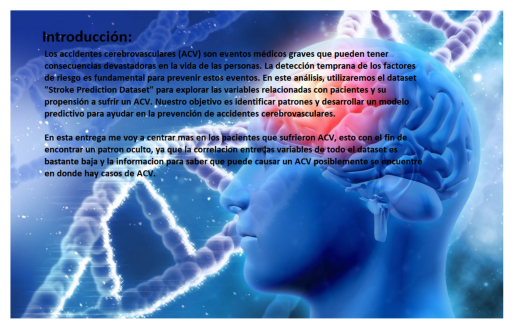

In [17]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\Introduccion.png'
mostrar_imagen(ruta_imagen)

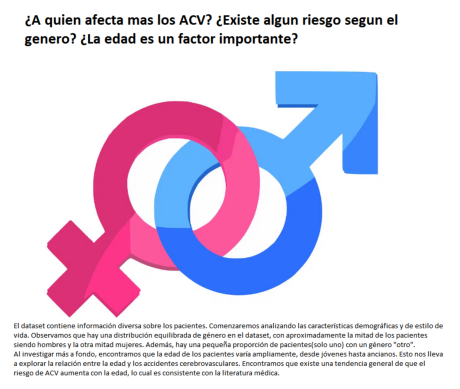

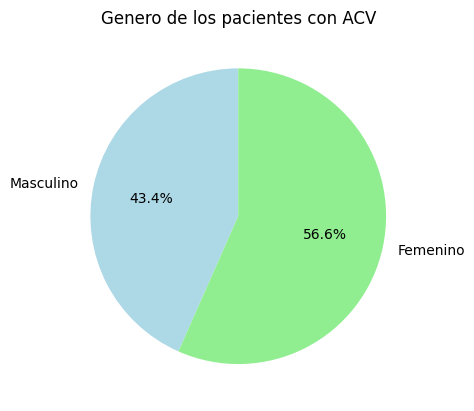

In [18]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\Genero.png'
mostrar_imagen(ruta_imagen)

# Cuenta los valores únicos en la columna "ever_married" del DataFrame df_stroke
married_counts = df_stroke['gender'].value_counts()

# Etiquetas y valores para el gráfico de torta
labels = ['Masculino', 'Femenino']
values = [married_counts[1], married_counts[0]]

# Colores para cada sector del gráfico de torta
colors = ['lightblue', 'lightgreen']

# Crea el gráfico de torta
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Genero de los pacientes con ACV')

plt.show()

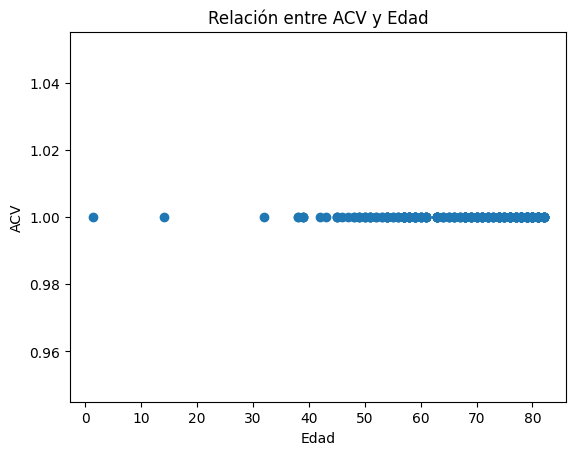

In [19]:
plt.scatter(df_stroke['age'], df_stroke['stroke'])
plt.xlabel('Edad')
plt.ylabel('ACV')
plt.title('Relación entre ACV y Edad')
plt.show()

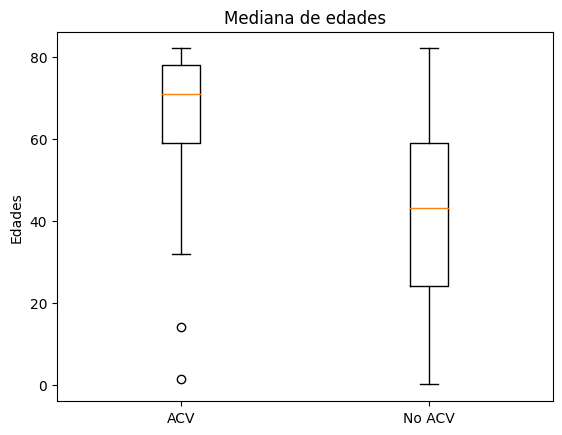

In [20]:
# Crea una lista con los datos de BMI y avr_glucose_level
acv = df_stroke['age']
no_acv = df_nostroke['age']
# Crea una lista con los nombres de las variables
labels = ['ACV', 'No ACV']

# Crea un boxplot con los datos
plt.boxplot([acv, no_acv], labels=labels)
plt.ylabel('Edades')
plt.title('Mediana de edades')

plt.show()

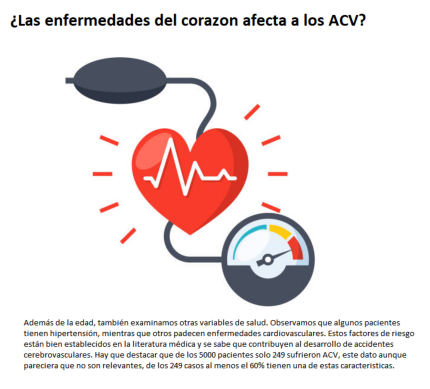

In [21]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\Corazon.png'
mostrar_imagen(ruta_imagen)


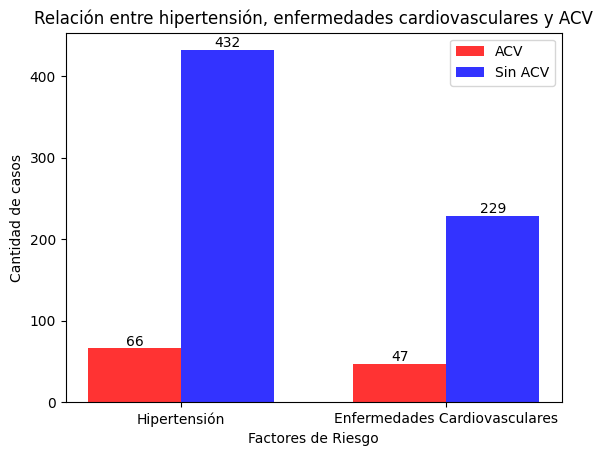

In [22]:
stroke_data = df[df['stroke'] == 1]
no_stroke_data = df[df['stroke'] == 0]

hypertension_stroke = stroke_data[stroke_data['hypertension'] == 1].shape[0]
hypertension_no_stroke = no_stroke_data[no_stroke_data['hypertension'] == 1].shape[0]

heart_disease_stroke = stroke_data[stroke_data['heart_disease'] == 1].shape[0]
heart_disease_no_stroke = no_stroke_data[no_stroke_data['heart_disease'] == 1].shape[0]

# Preparar los datos para el gráfico
stroke_data = [hypertension_stroke, heart_disease_stroke]
no_stroke_data = [hypertension_no_stroke, heart_disease_no_stroke]
x = np.arange(len(stroke_data))

# Ancho de las barras
bar_width = 0.35

# Etiquetas para las barras
labels = ['Hipertensión', 'Enfermedades Cardiovasculares']

# Colores para las barras
colors_stroke = ['red', 'red']
colors_no_stroke = ['blue', 'blue']

# Crear el gráfico de barras
plt.bar(x, stroke_data, width=bar_width, align='center', label='ACV', color=colors_stroke, alpha=0.8)
plt.bar(x + bar_width, no_stroke_data, width=bar_width, align='center', label='Sin ACV', color=colors_no_stroke, alpha=0.8)

# Añadir el valor numérico en cada barra
for i, v in enumerate(stroke_data):
    plt.text(i, v, str(v), color='black', ha='center', va='bottom')
for i, v in enumerate(no_stroke_data):
    plt.text(i + bar_width, v, str(v), color='black', ha='center', va='bottom')

# Configurar las etiquetas de los ejes y el título
plt.xlabel('Factores de Riesgo')
plt.ylabel('Cantidad de casos')
plt.title('Relación entre hipertensión, enfermedades cardiovasculares y ACV')
plt.xticks(x + bar_width/2, labels)
plt.legend()

# Mostrar el gráfico
plt.show()

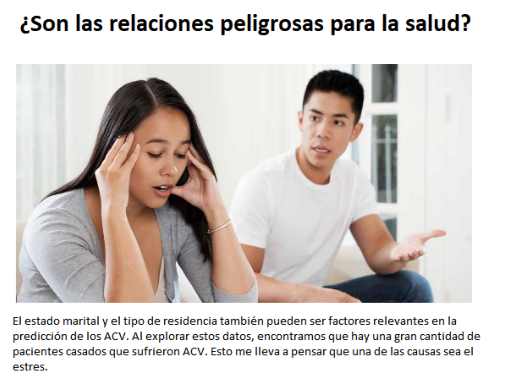

In [23]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\Pareja.png'
mostrar_imagen(ruta_imagen)

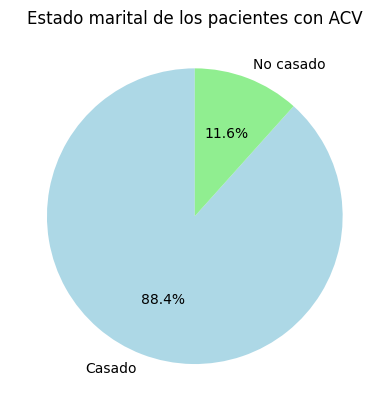

In [24]:
# Cuenta los valores únicos en la columna "ever_married" del DataFrame df_stroke
married_counts = df_stroke['ever_married'].value_counts()

# Etiquetas y valores para el gráfico de torta
labels = ['Casado', 'No casado']
values = [married_counts[1], married_counts[0]]

# Colores para cada sector del gráfico de torta
colors = ['lightblue', 'lightgreen']

# Crea el gráfico de torta
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Estado marital de los pacientes con ACV')

plt.show()

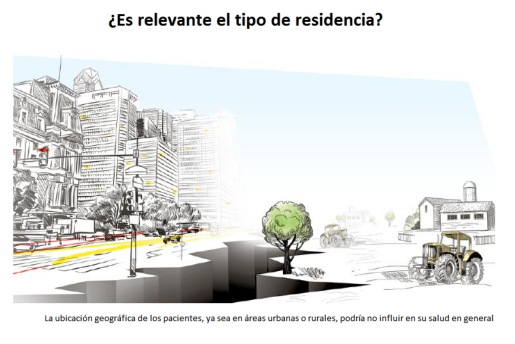

In [25]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\Residencia.png'
mostrar_imagen(ruta_imagen)

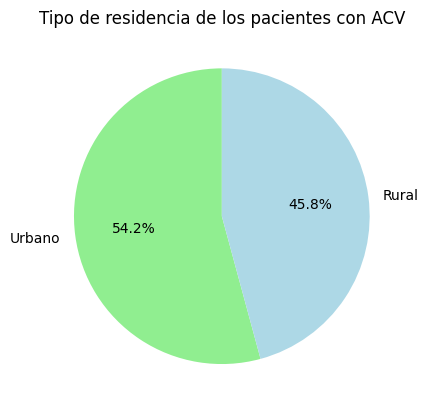

In [26]:
# Cuenta los valores únicos en la columna "Residence_type" del DataFrame df_stroke
residence_counts = df_stroke['Residence_type'].value_counts()

# Etiquetas y valores para el gráfico de torta
labels = ['Urbano', 'Rural']
values = [residence_counts[1], residence_counts[0]]

# Colores para cada sector del gráfico de torta
colors = ['lightgreen', 'lightblue']

# Crea el gráfico de torta
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Tipo de residencia de los pacientes con ACV')

plt.show()

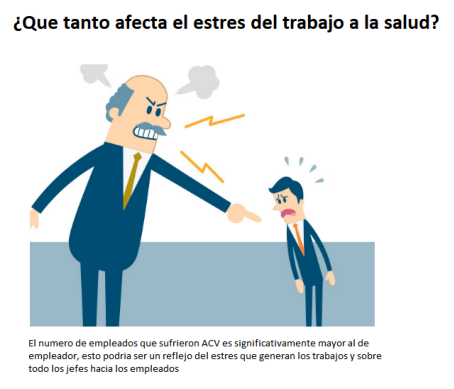

In [27]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\Trabajo.png'
mostrar_imagen(ruta_imagen)

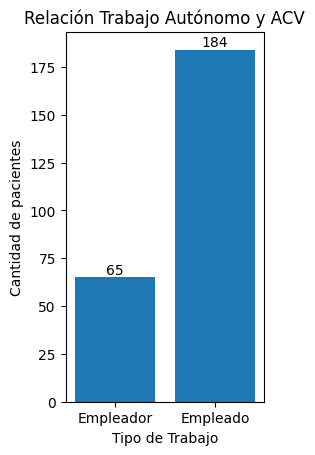

In [28]:
stroke_work = df_stroke['work_type_Self-employed'].value_counts()

labels_work = ['Empleador', 'Empleado']
values_work = [stroke_work[1], stroke_work[0]]

plt.subplot(1, 2, 2)
plt.bar(labels_work, values_work)
plt.xlabel('Tipo de Trabajo')
plt.ylabel('Cantidad de pacientes')
plt.title('Relación Trabajo Autónomo y ACV')
plt.subplots_adjust(wspace=0.5)


for i, v in enumerate(values_work):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

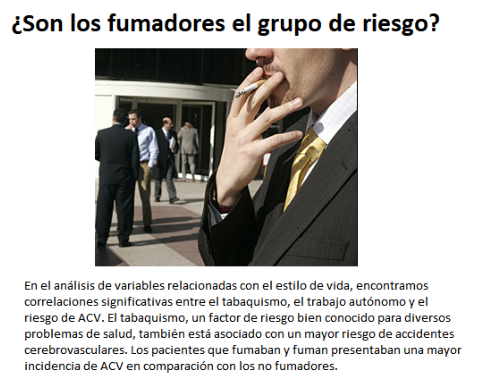

In [29]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\Fumador.png'
mostrar_imagen(ruta_imagen)

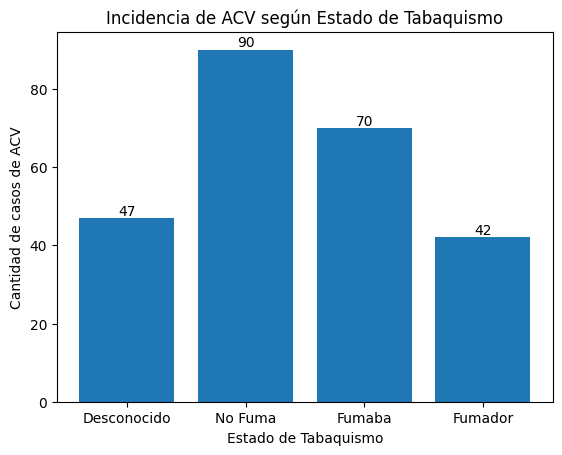

In [30]:
stroke_smoking = df_stroke[['smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']].sum()

labels_smoking = ['Desconocido', 'No Fuma', 'Fumaba', 'Fumador']
values_smoking = [stroke_smoking['smoking_status_Unknown'], stroke_smoking['smoking_status_never smoked'], stroke_smoking['smoking_status_formerly smoked'], stroke_smoking['smoking_status_smokes']]

plt.bar(labels_smoking, values_smoking)

for i, v in enumerate(values_smoking):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Estado de Tabaquismo')
plt.ylabel('Cantidad de casos de ACV')
plt.title('Incidencia de ACV según Estado de Tabaquismo')

plt.show()

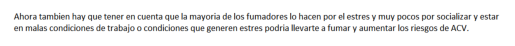

In [31]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\Ahora.png'
mostrar_imagen(ruta_imagen)

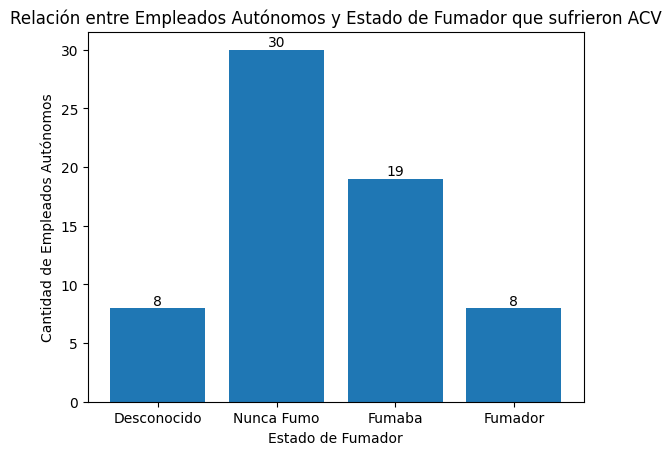

In [32]:
self_employed = df_stroke[df_stroke['work_type_Self-employed'] == 1]

smoking_counts = self_employed[['smoking_status_Unknown', 'smoking_status_never smoked', 'smoking_status_formerly smoked', 'smoking_status_smokes']].sum()

labels = ['Desconocido', 'Nunca Fumo', 'Fumaba', 'Fumador']

values = [smoking_counts['smoking_status_Unknown'], smoking_counts['smoking_status_never smoked'], smoking_counts['smoking_status_formerly smoked'], smoking_counts['smoking_status_smokes']]

plt.bar(labels, values)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Estado de Fumador')
plt.ylabel('Cantidad de Empleados Autónomos')
plt.title('Relación entre Empleados Autónomos y Estado de Fumador que sufrieron ACV')

plt.show()

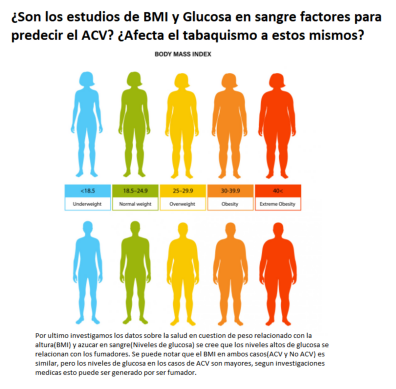

In [33]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\BMI.png'
mostrar_imagen(ruta_imagen)

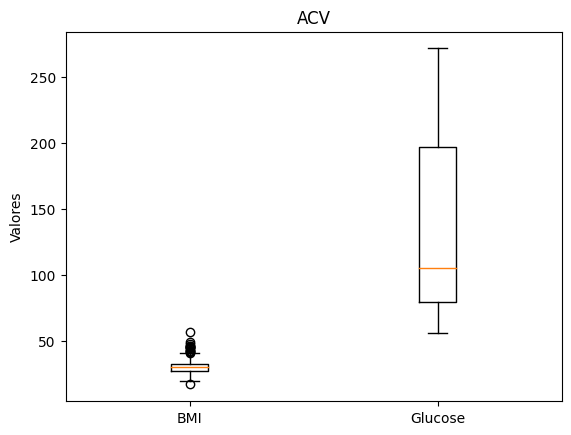

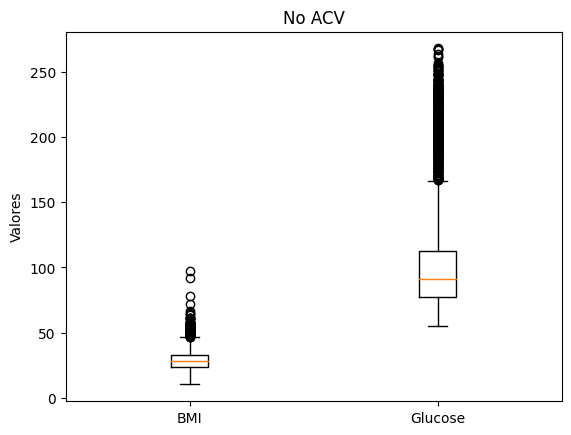

In [34]:
bmi_data = df_stroke['bmi']
glucose_data = df_stroke['avg_glucose_level']

# Crea una lista con los nombres de las variables
labels = ['BMI', 'Glucose']

# Crea un boxplot con los datos
plt.boxplot([bmi_data, glucose_data], labels=labels)
plt.ylabel('Valores')
plt.title('ACV')

plt.show()

bmi_data = df_nostroke['bmi']
glucose_data = df_nostroke['avg_glucose_level']

# Crea una lista con los nombres de las variables
labels = ['BMI', 'Glucose']

# Crea un boxplot con los datos
plt.boxplot([bmi_data, glucose_data], labels=labels)
plt.ylabel('Valores')
plt.title('No ACV')

plt.show()

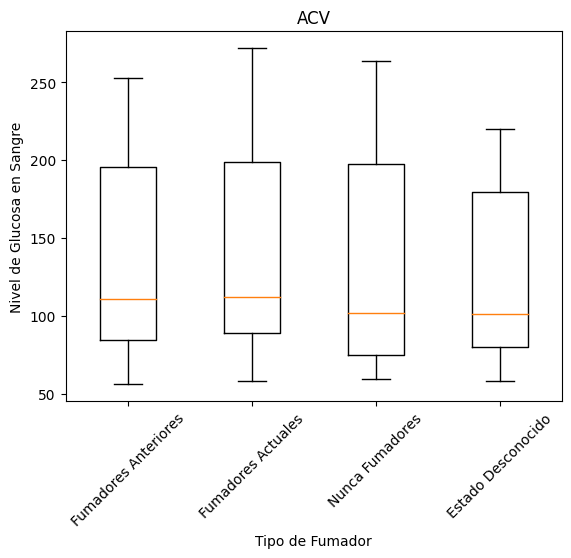

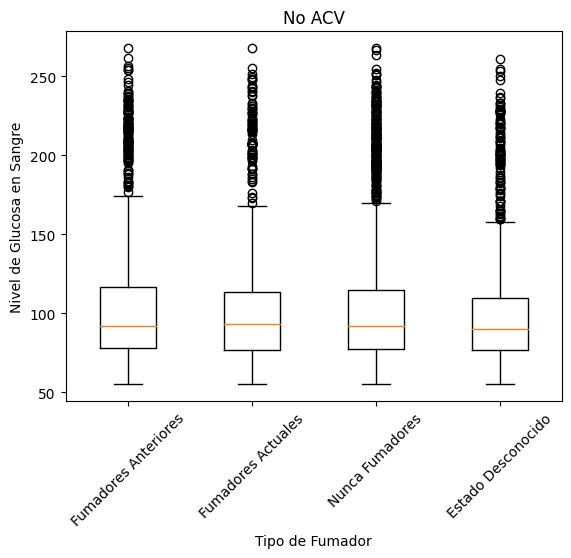

In [35]:
# Filtrar el DataFrame por cada tipo de fumador
former_smokers = df_stroke[df_stroke['smoking_status_formerly smoked'] == 1]
current_smokers = df_stroke[df_stroke['smoking_status_smokes'] == 1]
never_smokers = df_stroke[df_stroke['smoking_status_never smoked'] == 1]
unknown_smokers = df_stroke[df_stroke['smoking_status_Unknown'] == 1]

# Crear una lista con los datos de glucosa para cada tipo de fumador
data = [former_smokers['avg_glucose_level'],
        current_smokers['avg_glucose_level'],
        never_smokers['avg_glucose_level'],
        unknown_smokers['avg_glucose_level']]

# Etiquetas para el gráfico
labels = ['Fumadores Anteriores', 'Fumadores Actuales', 'Nunca Fumadores', 'Estado Desconocido']

# Crear el gráfico de caja
plt.boxplot(data, labels=labels)
plt.xlabel('Tipo de Fumador')
plt.ylabel('Nivel de Glucosa en Sangre')
plt.title('ACV')
plt.xticks(rotation=45)

plt.show()

# Filtrar el DataFrame por cada tipo de fumador
former_smokers = df_nostroke[df_nostroke['smoking_status_formerly smoked'] == 1]
current_smokers = df_nostroke[df_nostroke['smoking_status_smokes'] == 1]
never_smokers = df_nostroke[df_nostroke['smoking_status_never smoked'] == 1]
unknown_smokers = df_nostroke[df_nostroke['smoking_status_Unknown'] == 1]

# Crear una lista con los datos de glucosa para cada tipo de fumador
data = [former_smokers['avg_glucose_level'],
        current_smokers['avg_glucose_level'],
        never_smokers['avg_glucose_level'],
        unknown_smokers['avg_glucose_level']]

# Etiquetas para el gráfico
labels = ['Fumadores Anteriores', 'Fumadores Actuales', 'Nunca Fumadores', 'Estado Desconocido']

# Crear el gráfico de caja
plt.boxplot(data, labels=labels)
plt.xlabel('Tipo de Fumador')
plt.ylabel('Nivel de Glucosa en Sangre')
plt.title('No ACV')
plt.xticks(rotation=45)

plt.show()

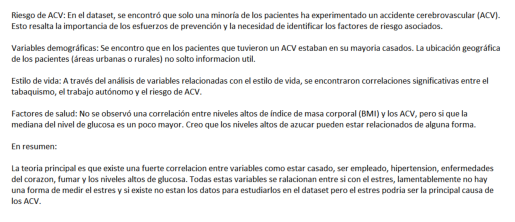

In [36]:
ruta_imagen = 'E:\App Exes\VS Code\Proyecto Final Data\Resumen.png'
mostrar_imagen(ruta_imagen)